### Introduction
Data preparation takes around 80% of any data practitioners' job (for most instances). Part of the work involves consolidating data across various data files into a single repository for data ingestion. Some of these processes could be automated and here, the notebook showcases several examples to go about it. Certainly it would not be a "one-size-fit-all" approach, considering the existing data management policies, tools and work processes that one has to work with, but hopefully, it would help inspire the ways to go about it for your own projects.

### Scenario
We have several excel worksheets - the task is to automate the combining of the data across these sheets. We would want to select only several columns of interest as well only. 

In [86]:
# import libraries
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import glob
import collections

In [122]:
plt.style.use('default')

### Part 1
Dealing with a single file

In [2]:
# load data of first file
df = pd.read_excel('./data_expt/2022_Jan_Norm.xlsx')
df.head(1)

,Year,Month,Expenditure,Sales
0,2022,1,100,1000.0


Great! we have the first file loaded. Check out the rows and columns, and also some descriptive stat summary while we are at it.

In [3]:
# assign the df rows and cols count to two variables ROWS and COLS
ROWS, COLS = df.shape[0], df.shape[1]
# print using f string
print(f'rows={ROWS}, cols={COLS}')

rows=50, cols=4


In [4]:
# Summary stats
df.describe()

,Year,Month,Expenditure,Sales
count,50.0,50.0,50.000000,45.000000
mean,2022.0,1.0,550.000000,5200.000000
std,0.0,0.0,290.144229,2904.541898
min,2022.0,1.0,100.000000,1000.000000
25%,2022.0,1.0,300.000000,3000.000000
50%,2022.0,1.0,550.000000,5000.000000
75%,2022.0,1.0,800.000000,7000.000000
max,2022.0,1.0,1000.000000,10000.000000


From summary stats, potential outlier values could be detected, as well as missing or erronous values -- it depends on the business context. Alternatively, we could check out presence of null values like so:


In [5]:
# Return null record count of cols
df.isnull().sum()

Year           0
Month          0
Expenditure    0
Sales          5
dtype: int64

Take a pause and consider what if we are potentially dealing with large numbers of columns in the future? Ideally, we want an approach that would help ease the strain on visually checking. We could return only column headers with null values only like so:


In [6]:
# Get the column with null value only
df[df.columns[df.isnull().sum() > 0]].isnull().sum()

Sales    5
dtype: int64

In [7]:
# Get the record where there is a null value
df[df.isnull().any(axis=1)]

,Year,Month,Expenditure,Sales
8,2022,1,900,NaN
17,2022,1,800,NaN
27,2022,1,800,NaN
37,2022,1,800,NaN
47,2022,1,800,NaN


In [8]:
# get the row numbers as a list for future checks
rowEmpty = list( df[df.isnull().any(axis=1)].index )
rowEmpty

[8, 17, 27, 37, 47]

We could also check for potential null values using packages such as missing no.

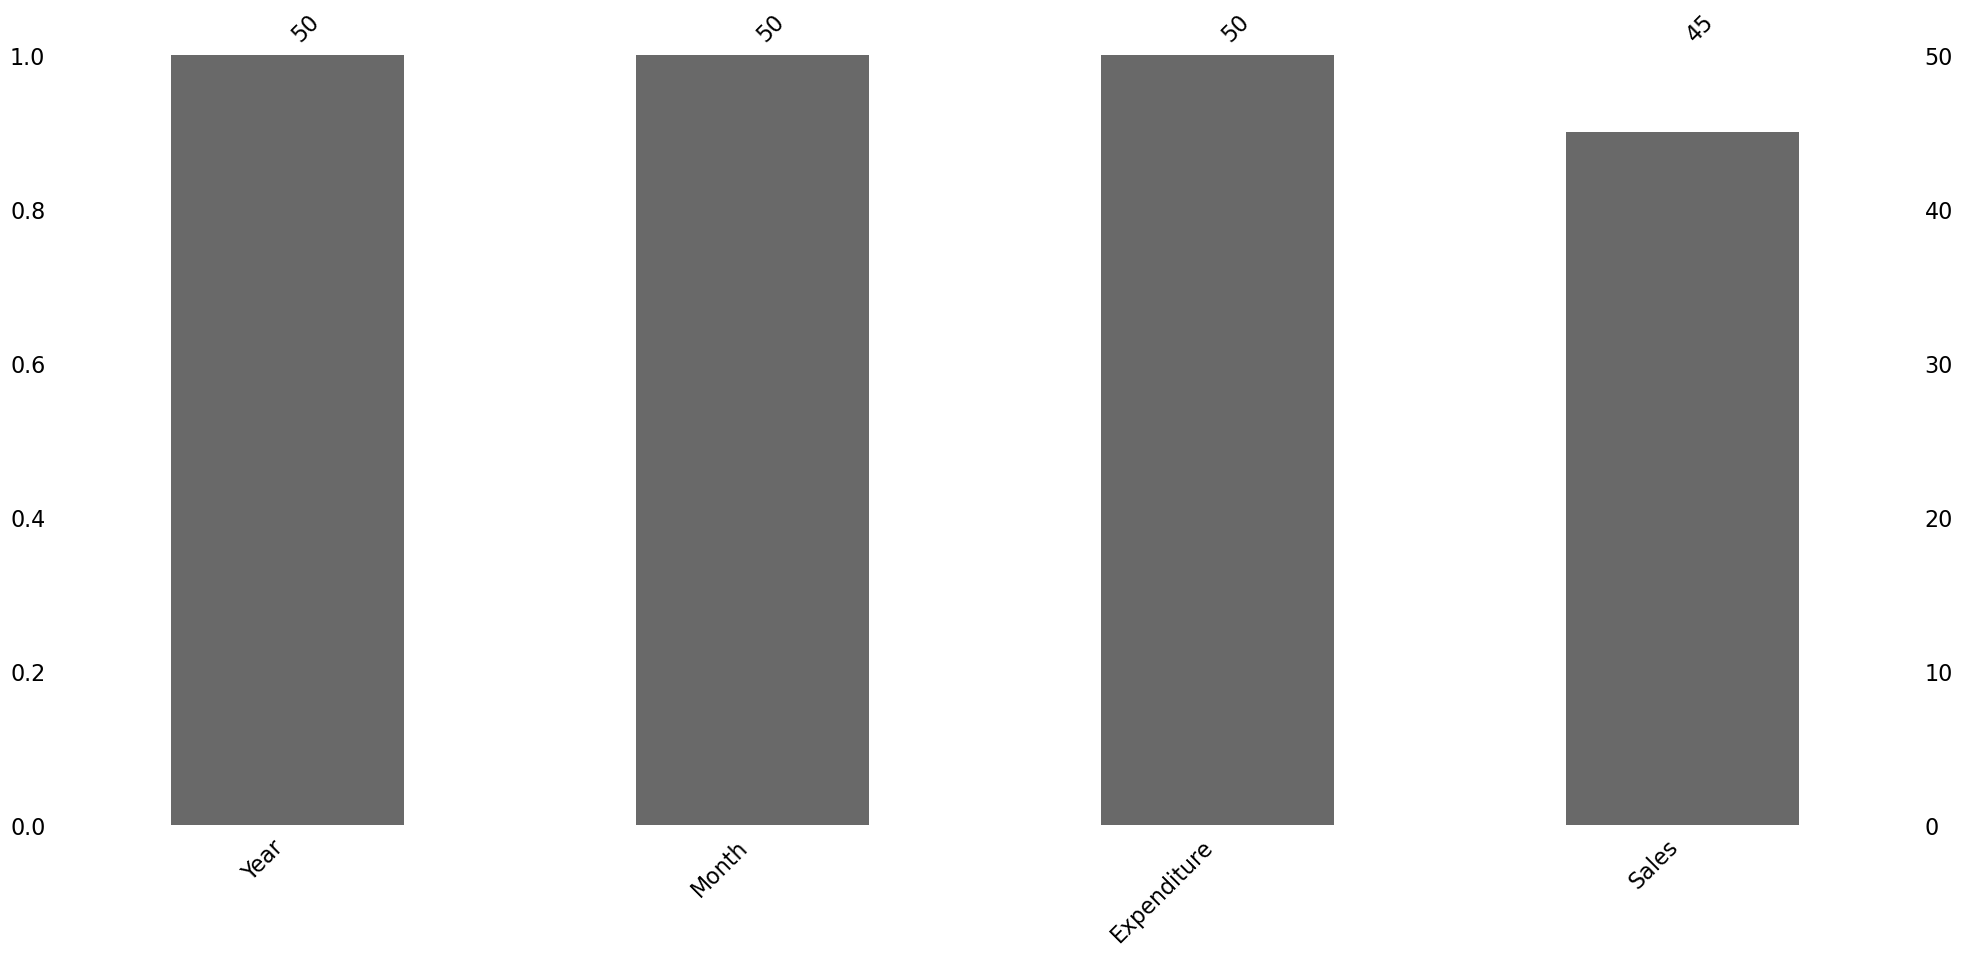

In [123]:
fig = plt.figure(figsize=(12,6))
fig = msno.bar(df)
plt.show()

Hmm. so, the input file has null values (for illustration). Let's replace the null value (not in the file but the dataframe). Imputation of missing values, again, depends on the business context. Sometimes, we may opt to drop the records with the missing values, other times we could infer the missing value from case-analysis. In this example, we could infer the missing value (i.e. 9000). We go through several common ways of filling missing value(s). 

In [10]:
# 1. fillna()
df_ = df.fillna(8000)
df_[df_.isnull().any(axis=1)]

,Year,Month,Expenditure,Sales


fillna() replaces all null values with the input value in the dataframe. If there are several records across different columsn with missing values, this method may not be what we need. There are other methods with fillna, such as using the previous values (i.e. `method` = 'pad') or next values (i.e. `method` = 'bfill'), but it's not hat we need here.

In [11]:
# 2. replace
df2_ = df.replace(to_replace=np.nan, value = 8000)
df2_[df2_.isnull().any(axis=1)]

,Year,Month,Expenditure,Sales


replace works similarly to fillna(). But observe that the replaced values may not necessarily be optimum. Following methods afford a greater degree of precision.

In [12]:
# 3. np.where
df3_ = df.copy()
df3_['Sales'] = np.where(( df3_['Sales'].isnull() ) & 
                         ( df3_['Expenditure']==800 ) , 8000, df3_['Sales'])
df3_['Sales'] = np.where(( df3_['Sales'].isnull() ) & 
                         ( df3_['Expenditure']==900 ) , 9000, df3_['Sales'])
# check replacement
df3_.loc[rowEmpty]

,Year,Month,Expenditure,Sales
8,2022,1,900,9000.0
17,2022,1,800,8000.0
27,2022,1,800,8000.0
37,2022,1,800,8000.0
47,2022,1,800,8000.0


In [13]:
# 4. interplolate
df4_ = df.copy()
df4_.interpolate(method ='linear', limit_direction ='forward', inplace =True)
# check replacement
df4_.loc[rowEmpty]

,Year,Month,Expenditure,Sales
8,2022,1,900,9000.0
17,2022,1,800,8000.0
27,2022,1,800,8000.0
37,2022,1,800,8000.0
47,2022,1,800,8000.0


In [14]:
# 5. sklearn's IterativeImputer
# Extract only numeric columns
numcol_lst = [col for col in df.columns if df[col].dtype != 'O']
df_n = df[numcol_lst]
print('dataframe cols:', df_n.columns)

dataframe cols: Index(['Year', 'Month', 'Expenditure', 'Sales'], dtype='object')


We will 
* declare an IterativeImputer object
* fit the IterativeImputer with the DataFrame
* transform the DataFrame with the IterativeImputer

In [15]:
# Declare a variable containing an IterativeImputer object
# set random state for reproducibility
imp = IterativeImputer(random_state=0)

# fit the DataFrame with numerical features into the IterativeImputer object
imp.fit(df_n)

# Transform the DataFrame with numerical features and assign it to a new variable
transformed_arr = imp.transform(df_n)

# Transform the array into a DataFrame
transformed_df = pd.DataFrame(transformed_arr,
                              columns = df_n.columns)

# check replacement
transformed_df.loc[rowEmpty]

,Year,Month,Expenditure,Sales
8,2022.0,1.0,900.0,9000.0
17,2022.0,1.0,800.0,8000.0
27,2022.0,1.0,800.0,8000.0
37,2022.0,1.0,800.0,8000.0
47,2022.0,1.0,800.0,8000.0


### Putting everything together (for one file)
From what we briefly covered, we could write a function to check the rows and columns of the dataframe, inform if there's any missing values. As for imputation, depending on how we want to treat the issue, we could first combine all data first then do the imputation or vice versa. For practice, we impute as we load the file.

In [16]:
# helper func to load data, inform the shape, presence of missing values, 
# and return a cleaned dataframe
def robot(filepath):
    print(f'processing file: {filepath[12:25]}')
    frame = pd.read_excel(filepath)
    ROWS, COLS = frame.shape[0], frame.shape[1]
    # print rows and cols qty using f string
    print(f'rows={ROWS}, cols={COLS}')
    # get cols with null values 
    colEmpty = frame[frame.columns[frame.isnull().sum() > 0]].isnull().sum()
    # get row numbers with any missing values
    rowEmpty = list( frame[frame.isnull().any(axis=1)].index )
    print(f'\nCols with null values\n{colEmpty}')
    print(f'\nrow no. with null values\n{rowEmpty}\n')
    
    # impute missing values if there are null values (numerical)
    if rowEmpty != []:
        imp = IterativeImputer(random_state=0)
        imp.fit(frame)
        transformed_arr = imp.transform(frame)
        frame = pd.DataFrame(transformed_arr,
                                         columns = frame.columns)
    # else pass 
    else:
        pass
    return frame

In [17]:
filepath = './data_expt/2022_Jan_Norm.xlsx'

In [18]:
robot(filepath)

processing file: 2022_Jan_Norm
rows=50, cols=4

Cols with null values
Sales    5
dtype: int64

row no. with null values
[8, 17, 27, 37, 47]



,Year,Month,Expenditure,Sales
0,2022.0,1.0,100.0,1000.0
1,2022.0,1.0,200.0,2000.0
2,2022.0,1.0,300.0,3000.0
3,2022.0,1.0,400.0,4000.0
4,2022.0,1.0,500.0,5000.0
5,2022.0,1.0,600.0,6000.0
6,2022.0,1.0,700.0,7000.0
7,2022.0,1.0,800.0,8000.0
8,2022.0,1.0,900.0,9000.0
9,2022.0,1.0,1000.0,10000.0


### Part 2
Dealing with multiple files. Here, we could have two potential use cases. One, simply combining all the files in the directory, two, a degree of control in combining specific files. Let's go through the simpler one first: combining all the file in one go.

In [124]:
# Get the string of file names that ends with .xlsx
xlsx = glob.glob('./data_expt/2022_*.xlsx')
xlsx.sort()
xlsx

['./data_expt\\2022_Apr_Ex.xlsx',
 './data_expt\\2022_Feb_Norm.xlsx',
 './data_expt\\2022_Jan_Norm.xlsx',
 './data_expt\\2022_Mar_Ex.xlsx']

Now that we have a list of all the .xlsx filenames, it's time to loop through them and repeat Part 1 iteratively to combine all the files.

In [125]:
# empty list to hold all the dataframes with each iteration
frames_list = []
# loop through the list
for element in xlsx:
    # call the function in part 1
    frame = robot(element)
    frames_list.append(frame)
    # combine
    res = pd.concat(frames_list)

res

processing file: 2022_Apr_Ex.x
rows=10, cols=6

Cols with null values
Series([], dtype: float64)

row no. with null values
[]

processing file: 2022_Feb_Norm
rows=50, cols=4

Cols with null values
Series([], dtype: float64)

row no. with null values
[]

processing file: 2022_Jan_Norm
rows=50, cols=4

Cols with null values
Sales    5
dtype: int64

row no. with null values
[8, 17, 27, 37, 47]

processing file: 2022_Mar_Ex.x
rows=10, cols=6

Cols with null values
Series([], dtype: float64)

row no. with null values
[]



,Year,Month,Expenditure,Sales,Type,HouseHold
0,2022.0,3.0,100.0,1000.0,Groceries,A
1,2022.0,3.0,200.0,2000.0,Groceries,B
2,2022.0,3.0,300.0,3000.0,Groceries,C
3,2022.0,3.0,400.0,4000.0,Groceries,D
4,2022.0,3.0,500.0,5000.0,Groceries,E
...,...,...,...,...,...,...
5,2022.0,3.0,600.0,6000.0,Groceries,F
6,2022.0,3.0,700.0,7000.0,Groceries,G
7,2022.0,3.0,800.0,8000.0,Utilities,H
8,2022.0,3.0,900.0,9000.0,Utilities,I


In [126]:
res.isnull().sum()

Year             0
Month            0
Expenditure      0
Sales            0
Type           100
HouseHold      100
dtype: int64

Notice we have many null values.. Why is that so? Going through the report, we see that files 3 and 4, (i.e. the one with Mar & Apr data, has additional columns). At this stage we need need to consider the approach of determining the required set of columns upfront - returning a dataframe with potentially many null values for unrequired columns is not desired. In terms of implementation, we could do this by masking.

In [21]:
# mask of required cols
mask = df.columns
mask

Index(['Year', 'Month', 'Expenditure', 'Sales'], dtype='object')

In [114]:
def robot2(filepath):
    print(f'processing file: {filepath[12:23]}')
    frame = pd.read_excel(filepath)
    ROWS, COLS = frame.shape[0], frame.shape[1]
    # print rows and cols qty using f string
    print(f'rows={ROWS}, cols={COLS}')
    # get cols with null values 
    colEmpty = frame[frame.columns[frame.isnull().sum() > 0]].isnull().sum()
    # get row numbers with any missing values
    rowEmpty = list( frame[frame.isnull().any(axis=1)].index )
    # get only the needed cols in frame_m
    frame_m = frame[mask]
    rowEmpty_m = list( frame_m[frame_m.isnull().any(axis=1)].index )
    # Report
    print(f'\nCols with null values\n{colEmpty}')
    print(f'\nrow no. with null values\n{rowEmpty}\n')
    
    # impute missing values if there are null values (numerical)
    if rowEmpty_m != []:
        imp = IterativeImputer(random_state=0)
        imp.fit(frame_m)
        transformed_arr = imp.transform(frame_m)
        frame_m = pd.DataFrame(transformed_arr,
                                         columns = frame_m.columns)
        rowEmpty_m = list( frame_m[frame_m.isnull().any(axis=1)].index )
        # Check for rows with missing values (there shouldn't be any)
        print(f'\nrow no. with null values after impuation\n{rowEmpty_m}\n')
    # else return the frame without imputation 
    else:
        pass
    return frame_m

In [115]:
# Shortened for loop using list comprehension
frames = [ robot2(element) for element in xlsx]
Res = pd.concat(frames)

processing file: 2022_Apr_Ex
rows=10, cols=6

Cols with null values
Series([], dtype: float64)

row no. with null values
[]

processing file: 2022_Feb_No
rows=50, cols=4

Cols with null values
Series([], dtype: float64)

row no. with null values
[]

processing file: 2022_Jan_No
rows=50, cols=4

Cols with null values
Sales    5
dtype: int64

row no. with null values
[8, 17, 27, 37, 47]


row no. with null values after impuation
[]

processing file: 2022_Mar_Ex
rows=10, cols=6

Cols with null values
Series([], dtype: float64)

row no. with null values
[]



In [116]:
# Check
print(Res.shape)
Res

(120, 4)


,Year,Month,Expenditure,Sales
0,2022.0,3.0,100.0,1000.0
1,2022.0,3.0,200.0,2000.0
2,2022.0,3.0,300.0,3000.0
3,2022.0,3.0,400.0,4000.0
4,2022.0,3.0,500.0,5000.0
...,...,...,...,...
5,2022.0,3.0,600.0,6000.0
6,2022.0,3.0,700.0,7000.0
7,2022.0,3.0,800.0,8000.0
8,2022.0,3.0,900.0,9000.0


### Part 3
In this section we deal with implementing a greater degree of precision in combining of files. For our use case, we combine only files by their suffix. As you may see, we could do this through conditional looping and applying the function above. But first, we need a way to determine the pattern of the file names. 

In [107]:
# review the list of filenames
xlsx

['./data_expt\\2022_Apr_Ex.xlsx',
 './data_expt\\2022_Feb_Norm.xlsx',
 './data_expt\\2022_Jan_Norm.xlsx',
 './data_expt\\2022_Mar_Ex.xlsx']

Here, we may already see that the end product would be two files from combining Ex and Norm suffix files. So, the workflow would be loop through all the files, and combine files based on similar suffix. The end number of combined files will depend on the number of unique suffixes.

In terms of implementation, we could imagine the files grouped together based on suffixes. A dictionary key-value pair system should do the trick -- key being the suffix, values being the list of all the relevant filenames. Then loop through the keys and corresponding filename values to combine the files.

In [108]:
# dictionary to manage the files
# suffix as key, file names as values
file_dir = collections.defaultdict(list)
for file in xlsx:
    suffix = file.split('_')[3].split('.')[0]
    file_dir[suffix].append(file)

file_dir

defaultdict(list,
            {'Ex': ['./data_expt\\2022_Apr_Ex.xlsx',
              './data_expt\\2022_Mar_Ex.xlsx'],
             'Norm': ['./data_expt\\2022_Feb_Norm.xlsx',
              './data_expt\\2022_Jan_Norm.xlsx']})

In [117]:
for k in file_dir.keys():
    print(file_dir[k])
    frames = [ robot2(element) for element in file_dir[k]]
    Res = pd.concat(frames)
    Res.to_excel('./data_expt/Combined '+ k + '.xlsx')

['./data_expt\\2022_Apr_Ex.xlsx', './data_expt\\2022_Mar_Ex.xlsx']
processing file: 2022_Apr_Ex
rows=10, cols=6

Cols with null values
Series([], dtype: float64)

row no. with null values
[]

processing file: 2022_Mar_Ex
rows=10, cols=6

Cols with null values
Series([], dtype: float64)

row no. with null values
[]

['./data_expt\\2022_Feb_Norm.xlsx', './data_expt\\2022_Jan_Norm.xlsx']
processing file: 2022_Feb_No
rows=50, cols=4

Cols with null values
Series([], dtype: float64)

row no. with null values
[]

processing file: 2022_Jan_No
rows=50, cols=4

Cols with null values
Sales    5
dtype: int64

row no. with null values
[8, 17, 27, 37, 47]


row no. with null values after impuation
[]



In [120]:
# Check if the combined files are correct
df_check1  = pd.read_excel('./data_expt/Combined Ex.xlsx',index_col=0)
print(df_check1.shape)
df_check1.head(1)

(20, 4)


,Year,Month,Expenditure,Sales
0,2022,3,100,1000


In [121]:
df_check2  = pd.read_excel('./data_expt/Combined Norm.xlsx',index_col=0)
print(df_check2.shape)
df_check2.head(1)

(100, 4)


,Year,Month,Expenditure,Sales
0,2022,2,100,1000.0


Ex files have total 10 records each, while Norm files have total 50 records each, so the above process checks out.